In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings

In [3]:
def _create_inactivity_mask(data, duration, threshold):

    if duration is None:
        return None

    # Create the mask filled iwith ones by default.
    mask = np.ones_like(data)

    # If duration is -1, return a mask with 1s for later manual edition.
    if duration == -1:
        return pd.Series(mask, index=data.index)

    # Binary data
    binary_data = np.where(data >= threshold, 1, 0)

    # The first order diff Series indicates the indices of the transitions
    # between series of zeroes and series of ones.
    # Add zero at the beginning of this series to mark the beginning of the
    # first sequence found in the data.
    edges = np.concatenate([[0], np.diff(binary_data)])

    # Test if there is no edge (i.e. no consecutive zeroes).
    if all(e == 0 for e in edges):
        return pd.Series(mask, index=data.index)

    # Indices of upper transitions (zero to one).
    idx_plus_one = (edges > 0).nonzero()[0]
    # Indices of lower transitions (one to zero).
    idx_minus_one = (edges < 0).nonzero()[0]

    # Even number of transitions.
    if idx_plus_one.size == idx_minus_one.size:

        # Start with zeros
        if idx_plus_one[0] < idx_minus_one[0]:
            starts = np.concatenate([[0], idx_minus_one])
            ends = np.concatenate([idx_plus_one, [edges.size]])
        else:
            starts = idx_minus_one
            ends = idx_plus_one
    # Odd number of transitions
    # starting with an upper transition
    elif idx_plus_one.size > idx_minus_one.size:
        starts = np.concatenate([[0], idx_minus_one])
        ends = idx_plus_one
    # starting with an lower transition
    else:
        starts = idx_minus_one
        ends = np.concatenate([idx_plus_one, [edges.size]])

    # Index pairs (start,end) of the sequences of zeroes
    seq_idx = np.c_[starts, ends]
    # Length of the aforementioned sequences
    seq_len = ends - starts

    for i in seq_idx[np.where(seq_len >= duration)]:
        mask[i[0]:i[1]] = 0

    return pd.Series(mask, index=data.index)

In [5]:
import os

file_path='../raw_data/'
df = pd.read_csv(os.path.join(file_path,'1_AHA_RAW.csv'))

df

,datetime,x_D,y_D,z_D,x_ND,y_ND,z_ND
0,2017-05-03 16:31:00.000000,-0.785,-0.086,-0.613,0.828,-0.051,0.531
1,2017-05-03 16:31:00.012500,-0.781,-0.090,-0.613,0.828,-0.059,0.531
2,2017-05-03 16:31:00.025000,-0.781,-0.090,-0.617,0.824,-0.055,0.527
3,2017-05-03 16:31:00.037500,-0.785,-0.090,-0.613,0.828,-0.055,0.531
4,2017-05-03 16:31:00.050000,-0.777,-0.094,-0.609,0.828,-0.059,0.527
...,...,...,...,...,...,...,...
95995,2017-05-03 16:50:59.937500,-0.918,0.180,0.211,0.480,-0.418,-0.711
95996,2017-05-03 16:50:59.950000,-0.934,0.215,0.176,0.508,-0.492,-0.680
95997,2017-05-03 16:50:59.962500,-0.922,0.168,0.121,0.598,-0.566,-0.660
95998,2017-05-03 16:50:59.975000,-0.871,0.074,0.082,0.664,-0.613,-0.656


In [6]:
data=df['x_D']

data

0       -0.785
1       -0.781
2       -0.781
3       -0.785
4       -0.777
         ...  
95995   -0.918
95996   -0.934
95997   -0.922
95998   -0.871
95999   -0.859
Name: x_D, Length: 96000, dtype: float64

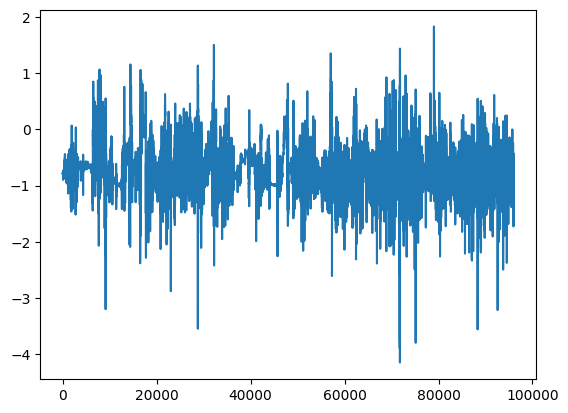

In [7]:
plt.plot(range(96000),data)

In [8]:
mask=_create_inactivity_mask(data,duration=120,threshold=-0.6)

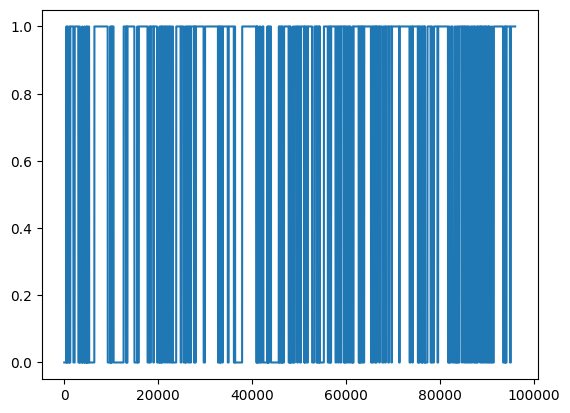

In [9]:
plt.plot(range(96000),mask)